In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlabel="$x$", ylabel="$y$")
    ax.axhline(0, color="black")
    ax.axvline(0, color="black")
    ax.grid(alpha=0.5)

### 7.1 Early stopping
The purpose of this exercise is to see how splitting up the available data in training, validation, and test data can help the fitting procedure becoming more reliable.

In [3]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

In [4]:
np.random.seed(0)
parabola = lambda x: 0.1*x**2 - 0.5*x - 6
xs_plot = torch.linspace(-10, 10, 100)
xs = torch.tensor(np.random.uniform(-10, 10, 50), dtype=torch.float32)
ys = parabola(xs) + 1.5*torch.randn_like(xs)

# Set random seed for reproducibility
torch.manual_seed(0)

# Total number of data points
n = xs.size(0)

# Shuffle indices
indices = torch.randperm(n)

# Define split sizes
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

# Split indices
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Split data
xs_train, ys_train = xs[train_indices], ys[train_indices]
xs_validation, ys_validation = xs[val_indices], ys[val_indices]
xs_test, ys_test = xs[test_indices], ys[test_indices]

# Wrap data in MyDataset
train_dataset = MyDataset(xs_train, ys_train)
val_dataset = MyDataset(xs_validation, ys_validation)
test_dataset = MyDataset(xs_test, ys_test)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Print sizes to verify
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")


Training set: 40 samples
Validation set: 5 samples
Test set: 5 samples


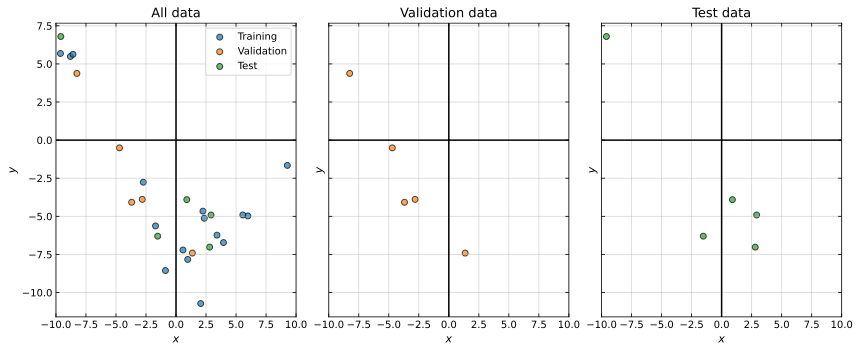

In [5]:
# Create a (1, 3) figure layout
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Plot all data in the first panel
for loader, label, color in zip([train_loader, val_loader, test_loader], 
                                ['Training', 'Validation', 'Test'], 
                                ['C0', 'C1', 'C2']):
    for data in loader:
        axes[0].scatter(data[0], data[1], label=label, alpha=0.7, edgecolor='k', c=color)
        break  # Plot a sample of each dataset
axes[0].set_title("All data")
axes[0].legend()

# Plot validation data in the second panel
for data in val_loader:
    axes[1].scatter(data[0], data[1], alpha=0.7, edgecolor='k', c='C1')
axes[1].set_title("Validation data")

# Plot test data in the third panel
for data in test_loader:
    axes[2].scatter(data[0], data[1], alpha=0.7, edgecolor='k', c='C2')
axes[2].set_title("Test data")

# Apply common settings to all axes
for ax in axes:
    nice_plot(ax)
    ax.set_xlim([-10, 10])

# Adjust layout and display
plt.tight_layout()
plt.show()

fig.savefig('ex53_fig1.png')

In [6]:
# Define the deep neural network class
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(DeepNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [7]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, early_stopping, epochs=100):
    """Train the model with early stopping and return training/validation losses."""
    # Lists to track loss values
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training step
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch[0].unsqueeze(1))  # Add dimension for input
            loss = loss_fn(outputs, batch[1].unsqueeze(1))  # Add dimension for target
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch[0].size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch[0].unsqueeze(1))
                loss = loss_fn(outputs, batch[1].unsqueeze(1))
                val_loss += loss.item() * batch[0].size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    return train_losses, val_losses, model

Training:  74%|███████▍  | 37/50 [00:00<00:00, 91.79it/s] 


Early stopping triggered at epoch 38


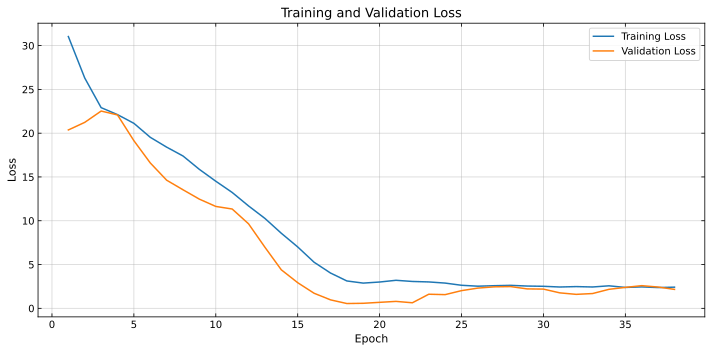

In [8]:
# Instantiate the model
model = DeepNeuralNetwork(input_size=1, output_size=1)

# Define the loss function, optimizer, and early stopping
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=20)

# Train the model
train_losses, val_losses, trained_model = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, early_stopping, epochs=50
)

# Plot the losses
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax.set_title("Training and Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

fig.savefig('ex53_fig2.png')

Training:   4%|▍         | 39/1000 [00:00<00:08, 106.83it/s]


Early stopping triggered at epoch 40


Training:  22%|██▏       | 219/1000 [00:02<00:08, 97.29it/s] 


Early stopping triggered at epoch 220


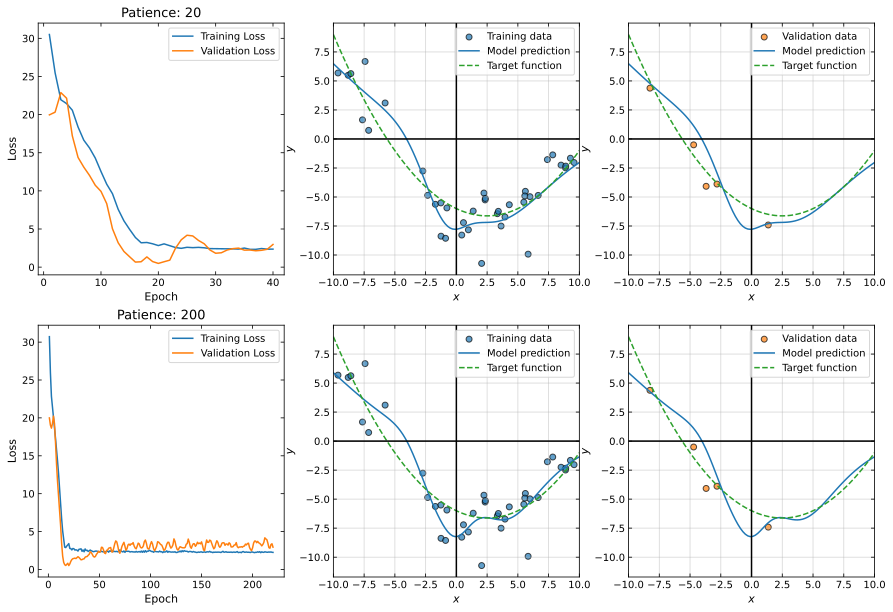

In [9]:
# Let's do it again twice and plot the results on other panels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
patiences = [20, 200]
for row, patience in zip(axes, patiences):
    # Instantiate the model
    model = DeepNeuralNetwork(input_size=1, output_size=1)

    # Define the loss function, optimizer, and early stopping
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=patience)

    # Train the model
    train_losses, val_losses, trained_model = train_model(
        model, train_loader, val_loader, loss_fn, optimizer, early_stopping, epochs=1000
    )

    # Plot the losses
    row[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    row[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    row[0].set_title(f"Patience: {patience}")
    row[0].set_xlabel("Epoch")
    row[0].set_ylabel("Loss")
    row[0].legend()
    
    # Plot the training and validation data, the target function, and the model prediction
    row[1].scatter(xs_train, ys_train, label='Training data', c="C0", edgecolor='k', alpha=0.7)
    row[2].scatter(xs_validation, ys_validation, label='Validation data', c="C1", edgecolor='k', alpha=0.7)
    for ax in row[1:]:
        ax.plot(xs_plot, trained_model(xs_plot.unsqueeze(1)).detach(), label='Model prediction', c="C0")
        ax.plot(xs_plot, parabola(xs_plot), label='Target function', c="C2", ls="--")
        nice_plot(ax)
        ax.set_xlim([-10, 10])
        ax.legend()
    row[2].sharey(row[1])

fig.savefig('ex53_fig3.png')

### 7.4 More data

Training set: 400 samples
Validation set: 50 samples
Test set: 50 samples


Training:   6%|▌         | 62/1000 [00:04<01:12, 12.86it/s]


Early stopping triggered at epoch 63


Training:  79%|███████▊  | 787/1000 [00:59<00:16, 13.25it/s]


Early stopping triggered at epoch 788


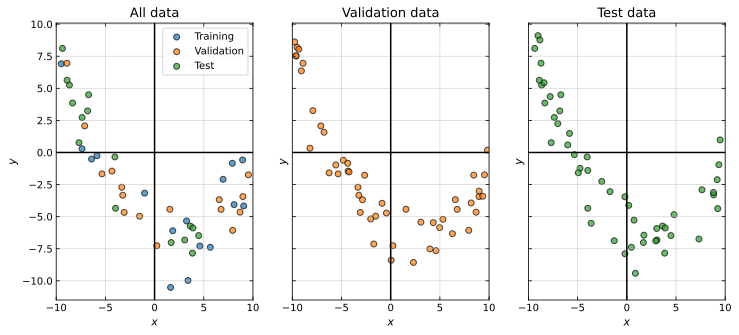

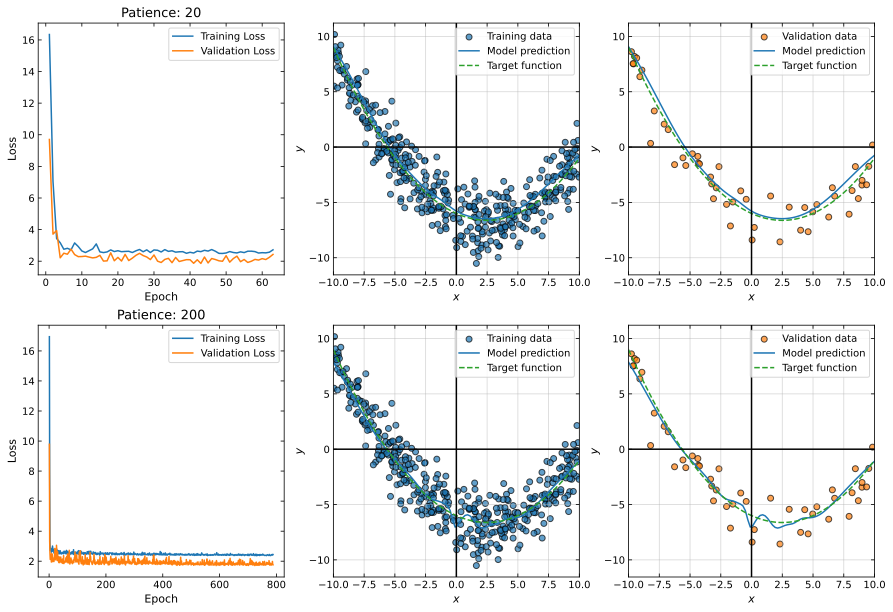

In [10]:
xs = torch.tensor(np.random.uniform(-10, 10, 500), dtype=torch.float32)
ys = parabola(xs) + 1.5*torch.randn_like(xs)

# Total number of data points
n = xs.size(0)

# Shuffle indices
indices = torch.randperm(n)

# Define split sizes
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

# Split indices
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Split data
xs_train, ys_train = xs[train_indices], ys[train_indices]
xs_validation, ys_validation = xs[val_indices], ys[val_indices]
xs_test, ys_test = xs[test_indices], ys[test_indices]

# Wrap data in MyDataset
train_dataset = MyDataset(xs_train, ys_train)
val_dataset = MyDataset(xs_validation, ys_validation)
test_dataset = MyDataset(xs_test, ys_test)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Print sizes to verify
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# ------------------------------------------------- #

# Create a (1, 3) figure layout
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Plot all data in the first panel
for loader, label, color in zip([train_loader, val_loader, test_loader], 
                                ['Training', 'Validation', 'Test'], 
                                ['C0', 'C1', 'C2']):
    for data in loader:
        axes[0].scatter(data[0], data[1], label=label, alpha=0.7, edgecolor='k', c=color)
        break  # Plot a sample of each dataset
axes[0].set_title("All data")
axes[0].legend()

# Plot validation data in the second panel
for data in val_loader:
    axes[1].scatter(data[0], data[1], alpha=0.7, edgecolor='k', c='C1')
axes[1].set_title("Validation data")

# Plot test data in the third panel
for data in test_loader:
    axes[2].scatter(data[0], data[1], alpha=0.7, edgecolor='k', c='C2')
axes[2].set_title("Test data")

# Apply common settings to all axes
for ax in axes:
    nice_plot(ax)
    ax.set_xlim([-10, 10])

fig.savefig('ex53_fig4.png')

# ------------------------------------------------- #

# Let's do it again twice and plot the results on other panels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
patiences = [20, 200]
for row, patience in zip(axes, patiences):
    # Instantiate the model
    model = DeepNeuralNetwork(input_size=1, output_size=1)

    # Define the loss function, optimizer, and early stopping
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=patience)

    # Train the model
    train_losses, val_losses, trained_model = train_model(
        model, train_loader, val_loader, loss_fn, optimizer, early_stopping, epochs=1000
    )

    # Plot the losses
    row[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    row[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    row[0].set_title(f"Patience: {patience}")
    row[0].set_xlabel("Epoch")
    row[0].set_ylabel("Loss")
    row[0].legend()
    
    # Plot the training and validation data, the target function, and the model prediction
    row[1].scatter(xs_train, ys_train, label='Training data', c="C0", edgecolor='k', alpha=0.7)
    row[2].scatter(xs_validation, ys_validation, label='Validation data', c="C1", edgecolor='k', alpha=0.7)
    for ax in row[1:]:
        ax.plot(xs_plot, trained_model(xs_plot.unsqueeze(1)).detach(), label='Model prediction', c="C0")
        ax.plot(xs_plot, parabola(xs_plot), label='Target function', c="C2", ls="--")
        nice_plot(ax)
        ax.set_xlim([-10, 10])
        ax.legend()
    row[2].sharey(row[1])

fig.savefig('ex53_fig5.png')

In [11]:
len(xs)

500